**Predicting Affecting the Current Rank of Professional Singles Male Tennis Players**

**Introduction:**
The performance of professional male tennis players is accessed objectively by the Association of Tennis Professionals (ATP) ranking system. Players gain points according to their round of exit and the scale of the tournament. Typically, points are valid for 52 weeks.
This project uses the player_stat dataset to predict the current rank of professional singles male tennis players by age and experience, thus answering the research questions:
How does age affect players’ current rank?
How does experience, as reflected by seasons played, affect players’ current rank? 
The player_stat dataset contains information on singles male tennis players ranked in the top 500 in the ATP scoring system from 2020. The columns are defined below:
Age;
Current rank: refers to ATP rank;
Seasons played: a season is defined as a calendar year in professional tennis.

**Preliminary exploratory data analysis:**

In [1]:
#Load libraries here
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)
library(dplyr)
library(GGally)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#Read data
tennis_data_raw <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



In [3]:
#Tidying data

names(tennis_data_raw) <- make.names(names(tennis_data_raw), unique = TRUE)
tennis_data_tidy <- tennis_data_raw %>% 
mutate(Last_Appearance = Last.Appearance) %>%
select(-Wikipedia, -X1) %>%
#Separating values
separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
separate(col = Current.Rank, into = c("Current_Rank", "Points_at_Current_Rank"), sep = " ") %>% 
separate(col = Best.Rank, into = c("Best_Rank", "Best_Rank_Date"), sep = " ") %>%
separate(col = Current.Elo.Rank, into = c("Current_Elo_Rank", "Current_Elo_Score"), sep = " ") %>% 
separate(col = Best.Elo.Rank, into = c("Best_Elo_Rank", "Best_Elo_Rank_Date"), sep = " ") %>% 
separate(col = Peak.Elo.Rating, into = c("Peak_Elo_Rating", "Peak_Elo_Rating_Date"), sep = " ") %>% 
separate(col = GOAT.Rank, into = c("GOAT_Rank", "GOAT_Points"), sep = " ") %>%
lapply( function(x) gsub(pattern = "[\\(\\)]",replacement = "", as.character(x))) %>%
data.frame() %>%
#Converting Date format
separate(col = Birthdate, into = c("Birthday","Birthmonth", "Birthyear"), sep = "-") %>% 
separate(col = Best_Rank_Date, into = c("Best_Rank_Day", "Best_Rank_Month", "Best_Rank_Year"), sep = "-") %>%
separate(col = Peak_Elo_Rating_Date, into = c("Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month" ,"Peak_Elo_Rating_Year"), sep = "-") %>%
separate(col = Best_Elo_Rank_Date, into = c("Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year"), sep = "-") %>%
separate(col = Last_Appearance, into = c("Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year"), sep = "-") %>%
#Converting to int
mutate_at(c("Age", "Birthday", "Birthmonth", "Birthyear", "Current_Rank", "Points_at_Current_Rank", "Current_Elo_Rank", "Best_Rank", "Best_Rank_Day", "Current_Elo_Score",
            "Best_Rank_Year", "Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month", "Peak_Elo_Rating_Year", "Peak_Elo_Rating", "Best.Season", "Retired",
            "Best_Elo_Rank", "Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year","Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year", 
            "GOAT_Rank", "GOAT_Points", "Grand.Slams", "Davis.Cups", "Olympics", "Team.Cups", "Turned.Pro", "Seasons", "Titles" ), as.integer) %>%
mutate( Age_at_Best_Rank = Best_Rank_Year - Birthyear)
       
tennis_data_tidy$Retired[tennis_data_tidy$Retired > 1990] <- "yes"
tennis_data_tidy$Retired[is.na(tennis_data_tidy$Retired)] <- "no"
       
#Removed many vectors for easier viewing of table
tennis_data_filtered <- tennis_data_tidy %>%
                   #Removed irrelevant columns
                   select(-Facebook, - Twitter, - Nicknames, -Coach, -Web.Site, -Residence, -Birthplace) %>%      
                   #Removed columns with mostly NA 
                   select(-Davis.Cups, -Team.Cups, -Olympics, -Weight, -Grand.Slams, -Tour.Finals,-Masters, -Weeks.at.No..1, 
                           -Height, -Prize.Money, -Last.Appearance, -Titles, -Active) %>%       
                   #Removed ddys, months and years
                   select(-Birthday, -Birthmonth, -Birthyear, -Best_Rank_Day, -Best_Rank_Month, -Best_Rank_Year,
                          -Peak_Elo_Rating_Day, -Peak_Elo_Rating_Month, -Peak_Elo_Rating_Year,
                          -Best_Elo_Rank_Day, -Best_Elo_Rank_Month, - Last_Appearance_Day, -Last_Appearance_Month,-Last_Appearance_Year, Best.Season) %>% 
                   #Removed non-numeric columns
                   select(-Country, -Plays, -Favorite.Surface, -Name, -Turned.Pro, -Retired, -Backhand)%>%
                   arrange(Current_Rank)
           
 head(tennis_data_filtered, 10)

,Age,Current_Rank,Points_at_Current_Rank,Best_Rank,Seasons,Current_Elo_Rank,Current_Elo_Score,Best_Elo_Rank,Best_Elo_Rank_Year,Peak_Elo_Rating,GOAT_Rank,GOAT_Points,Best.Season,Age_at_Best_Rank
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,10235,1,19,1,2406,1,2008,2552,3,805,2010,22
2,32,2,9720,1,17,2,2390,1,2011,2629,2,819,2015,24
3,38,3,6590,1,22,3,2328,1,2003,2550,1,929,2006,23
4,23,4,5960,4,5,5,2204,4,2019,2243,109,27,2019,23
5,26,5,5890,4,10,6,2188,5,2019,2211,58,58,2019,24
6,21,6,5375,5,4,8,2160,8,2019,2175,139,21,2019,21
7,22,7,3345,3,8,13,2096,5,2017,2231,65,54,2018,20
8,23,8,2870,8,3,17,2075,13,2019,2102,245,7,2019,23
9,31,9,2630,9,11,16,2080,9,2019,2135,151,18,2019,31


In [4]:

tennis_clean <- filter(tennis_data_filtered, Current_Rank != is.na(Current_Rank))
tennis_split <- initial_split(tennis_clean, prop = 0.75, strata = Current_Rank)
tennis_training_exploratory <- training(tennis_split)
tennis_testing_exploratory <- testing(tennis_split)


In [5]:
#Figure 1
tennis_table <- tennis_training_exploratory %>%
                     arrange(Current_Rank) %>%
                     head(10) %>%
                     select(Age, Current_Rank, Age_at_Best_Rank, Best_Rank)
tennis_table

,Age,Current_Rank,Age_at_Best_Rank,Best_Rank
,<int>,<int>,<int>,<int>
1,32,2,24,1
2,38,3,23,1
3,23,4,23,4
4,26,5,24,4
5,21,6,21,5
6,23,8,23,8
7,31,9,31,9
8,33,10,30,6
9,29,11,27,7


In [6]:
tennis_pairs_1 <- tennis_training_exploratory %>%
                  select(2,1, 3:7)

tennis_pairs_2 <- tennis_training_exploratory %>%
                  select(2, 8:14)

#Figure 2
tennis_eda_1 <- tennis_pairs_1 %>%
                ggpairs() 
                geom_point()
#Figure 3
tennis_eda_2 <- tennis_pairs_2 %>%
                ggpairs() 
                geom_point()
#tennis_eda_1
#tennis_eda_2

geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

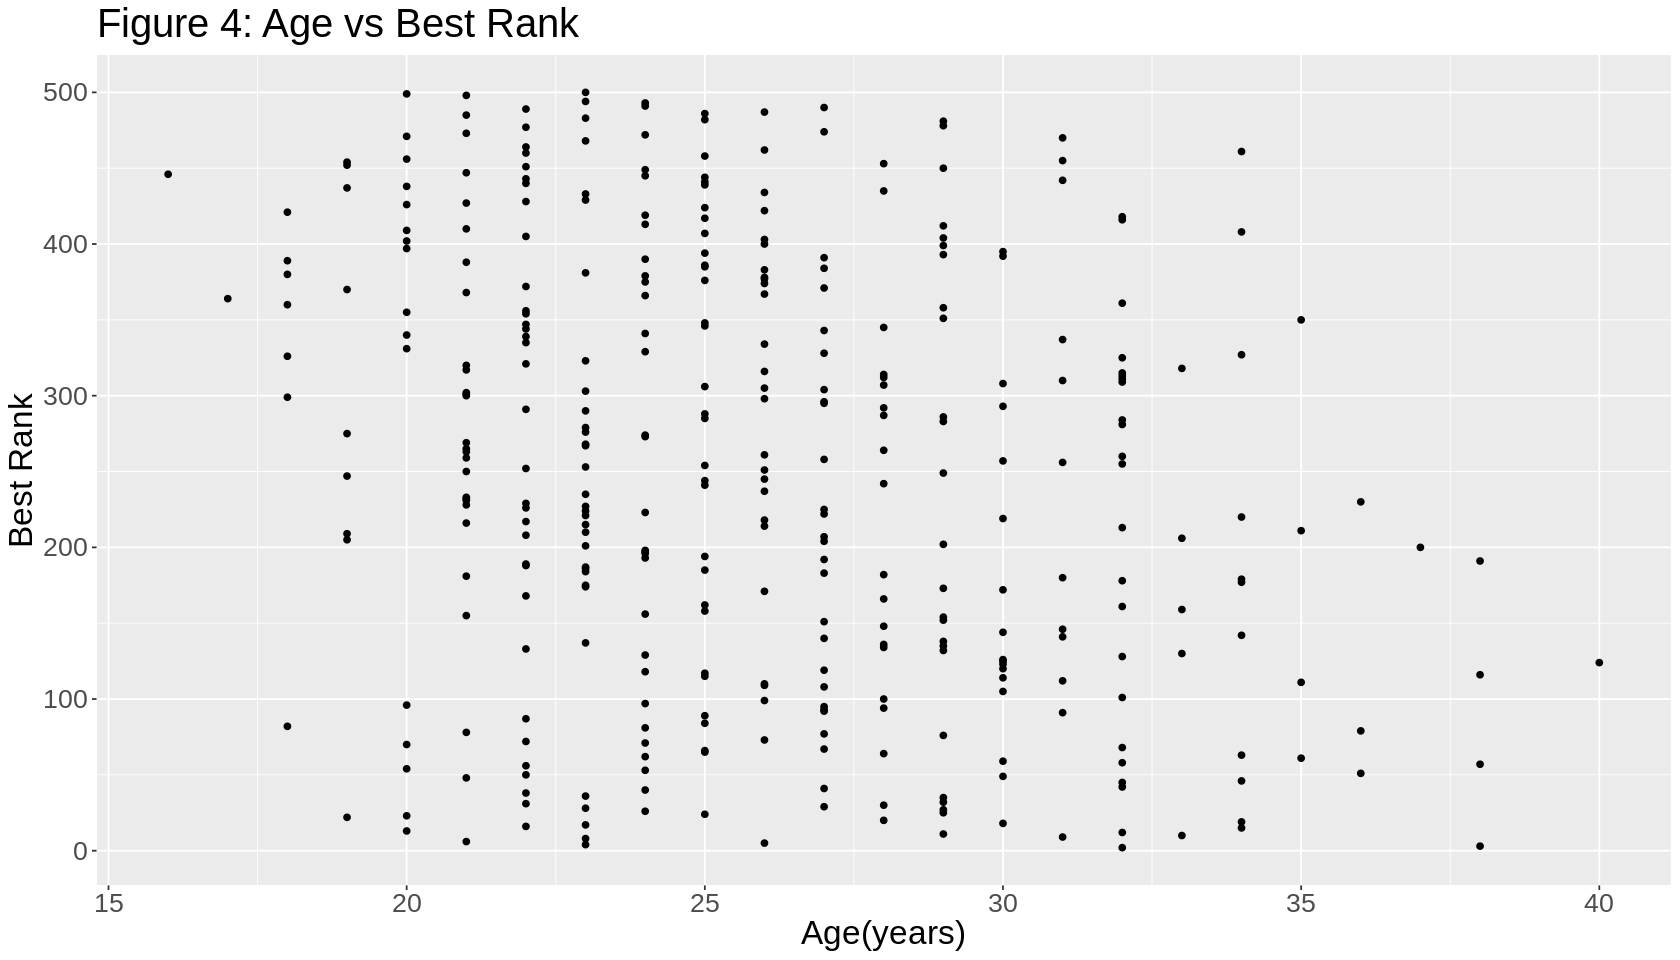

In [7]:
#Relevant Plot
options(repr.plot.width = 14, repr.plot.height = 8)
#Figure 4
age_best_rank <- tennis_training_exploratory %>%
                    ggplot(aes(x = Age, y= Current_Rank)) +
                    geom_point() +
                    labs(x = "Age(years)", y = "Best Rank") +
                    theme(text = element_text(size =20)) +
                    ggtitle("Figure 4: Age vs Best Rank")
age_best_rank

**Methods**

-Set the seed for our data so our methods are reproducible;

-Split the dataset into a training and test set.

-Use cross-validation to calculate the best K for the most accurate results, using the root mean square error (RMSPE):
 
-Create a recipe to scale and center our predictor variables using recipe(), step_scale(), and step_center() using only our training set.

-Create the model using nearest_neighbor(), set_engine(), set_mode(), and setting the neighbors argument to tune().

-Use the vfold_cv() and stratify by current_rank to create cross-validation object. 

-Make workflow using recipe and model. Observe how the number of neighbors affects RMSPE.

-Create a grid of numbers 1:300 using tibble() and collect_metrics(), to see what RMSPE value is given for each K value used in the model. To find the best K value for our model (producing the lowest RMSPE), filter  results to find minimum RMSPE value and the corresponding K value.

-Evaluate the model: re-training it using the training set and K value obtained from the previous step. 

-Use predict() to predict current rank values for the test set data. Use bind_cols() to add a column of predictions to the test set for comparison with true values.

-Summarize accuracy of known test set current rank values to the predicted current rank values using metrics(). 

-Use model to make predictions about current rank for new observations.

**Expected outcomes and significance**

This project expects to determine how age and experience (reflected by seasons played) affect a players’ current rank. The hypothesis is that players would obtain higher ranks as they age and gain more experience (have more seasons played). Circumstances such as illness and injury that might halt players’ careers are not taken into account in this project. 
It was commonly believed that players’ physical strength would deteriorate over years. However, some current players such as Novak Djokovic, Rafael Nadal, and Roger Federer are able to win major tournaments such as Grand Slams after they reach 30, a relatively senior age for professional tennis players. This project would give a vision of to what extent current players lengthen their peak and careers, perhaps due to improving training methods and medical technology. 
The project could lead to future questions such as:

Do age and experience play a similar role in determining the current rank of players in other types of tennis games such as Men’s doubles, Women’s singles, and Mixed doubles.

Quantitatively determine to what extent age and seasons played each contribute into a players’ current rank, and whether they share a similar weight in determining the players’ current rank.

Are other racket sports such as badminton and squash also affected the same way as tennis when it comes to factors such as age and experience, or are they affected differently?


In [8]:
tennis_training <- tennis_training_exploratory %>%
                         filter(Age != is.na(Age)) %>%
                         filter(Seasons != is.na(Seasons)) %>%
                         select(Current_Rank, Seasons, Age) 

tennis_testing <- tennis_testing_exploratory %>%
                         filter(Age != is.na(Age)) %>%
                         filter(Seasons != is.na(Seasons)) %>%
                         select(Current_Rank, Seasons, Age) 


In [9]:
tennis_recipe <- recipe(Current_Rank ~Seasons + Age, data = tennis_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("regression")

tennis_vfold <- vfold_cv(tennis_training, v = 10, strata = Current_Rank)

tennis_wkflw <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec)

In [10]:
gridvals <- tibble(neighbors = seq(from = 1,to =  200, by= 2)) 

tennis_results <- tennis_wkflw %>%
                  tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
                  collect_metrics() 

In [11]:
tennis_min <- tennis_results %>%
              filter(.metric == "rmse") %>%
              filter(mean == min(mean))
tennis_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,rmse,standard,114.12,10,3.889084,Model010


In [12]:
kmin <- tennis_min %>% pull(neighbors)

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

tennis_fit <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(tennis_spec) %>%
  fit(data = tennis_training)


In [13]:
tennis_summary <- tennis_fit %>%
  predict(tennis_testing) %>%
  bind_cols(tennis_testing) %>%
  metrics(truth = Current_Rank, estimate = .pred) %>%
  filter(.metric == "rmse")

tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,116.8706


In [14]:
tennis_preds <- tibble(Age = seq(from = 17, to = 40, by = 1), Seasons = seq(from = 0, to = 23, by = 1))
tennis_preds <- tennis_fit %>%
  predict(tennis_preds) %>%
  bind_cols(tennis_preds)

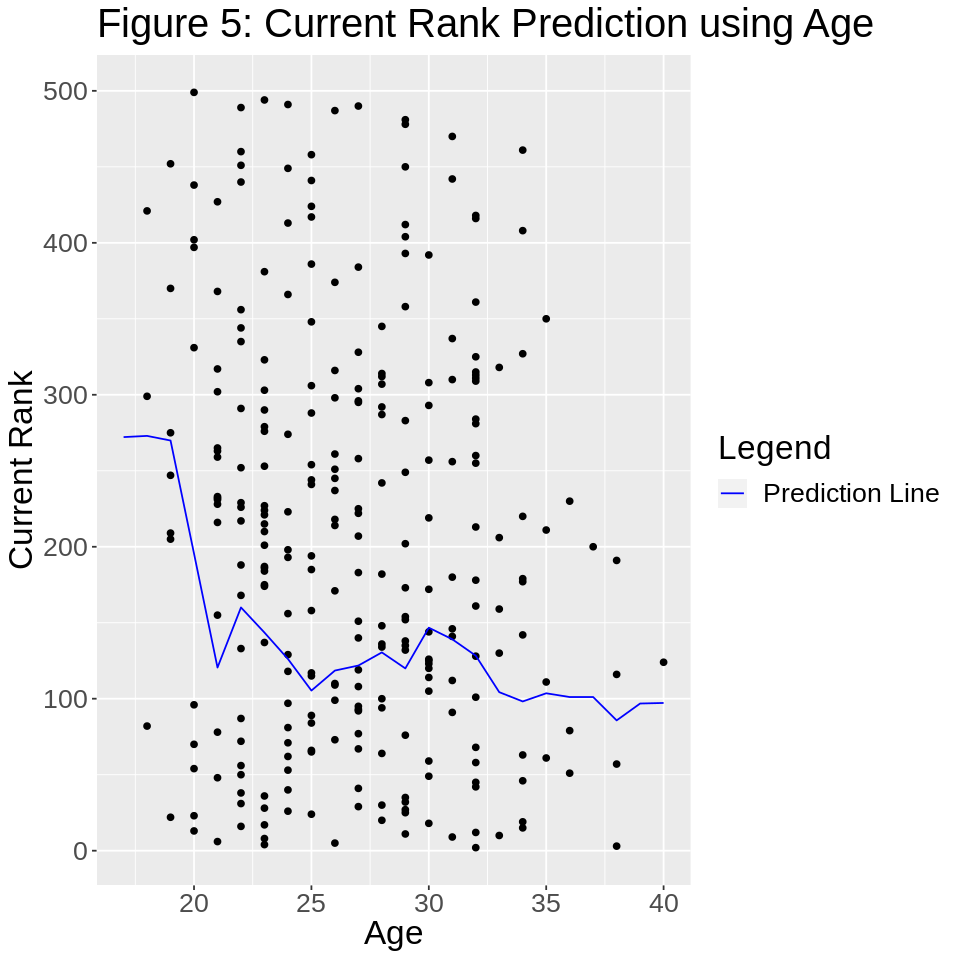

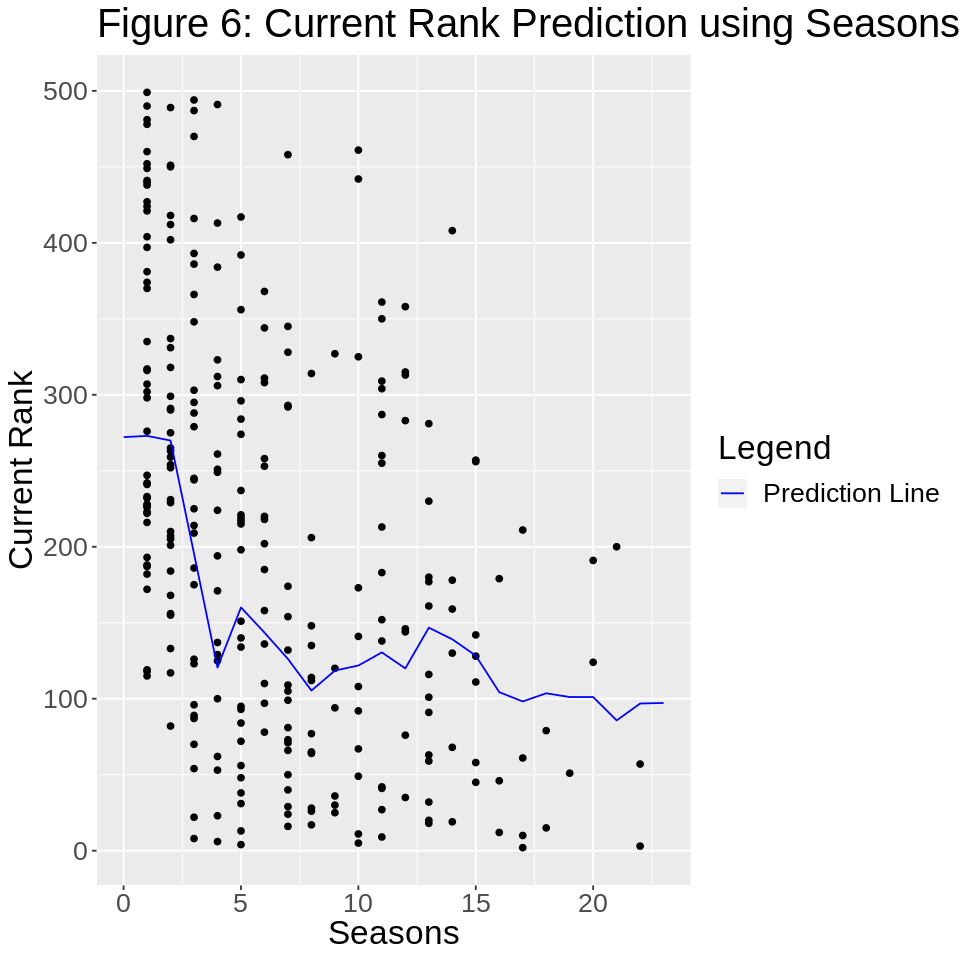

In [15]:
options(repr.plot.width = 8, repr.plot.length = 1)
#Figure 5
plot_Age <- ggplot(tennis_training, aes(x = Age, y = Current_Rank)) +
              geom_point() +
              geom_line(data = tennis_preds, 
                    mapping = aes(x = Age, y = .pred, color = "Prediction Line")) +
              scale_color_manual(name = "Legend", values = c("Prediction Line" = "blue")) +
              theme(text = element_text(size=20)) +
              xlab("Age") +
              ylab("Current Rank") +
              ggtitle("Figure 5: Current Rank Prediction using Age")
#Figure 6
plot_Seasons <- ggplot(tennis_training, aes(x = Seasons, y = Current_Rank)) +
                  geom_point() +
                  geom_line(data = tennis_preds, 
                  mapping = aes(x = Seasons, y = .pred, color = "Prediction Line")) +
                  scale_color_manual(name = "Legend", values = c("Prediction Line" = "blue")) +
                  theme(text = element_text(size=20)) +
                  xlab("Seasons") +
                  ylab("Current Rank") + 
                  ggtitle("Figure 6: Current Rank Prediction using Seasons")
plot_Age
plot_Seasons